# MFS Interview Case Study: Employee Turnover Prediction

Erin Keough\
22 October 2025\
erinkeough@ymail.com

**Business Question**: Can we predict which employees are most at risk of attrition, so HR can take proactive steps to improve retention?

**Business Value**:
- Reduce attrition costs (for example, recruiting, training, knowledge loss)
- Improve retention of high-performing employees
- Data-driven workforce planning

## Assumptions

In modeling employee turnover with this IBM HR Attrition dataset, we are implicitly making several assumptions, which I will categorize into Data, Modeling, and Business Assumptions.

**Data Assumptions**

*Representative Sample of Employees*
* We assume that the IBM dataset represents the population of employees we want to make predictions for, but since this is mock data, it may not reflect real-world HR dynamics

*Sampling Bias & Completeness*
* We assume the data has not excluded certain groups (e.g., interns, senior executives); if sampling bias exists, this could lead to over- or under-predicting for certain groups
* We also assume that all columns are measured correctly and consistently (e.g., satisfaction fields), when in reality, HR survey data is often missing

*Temporal Stability & Stationarity*
* A large assumption made with this dataset is that the relationships between features and attrition remain stable over time, when things like management or policy changes can alter employee satisfaction features dramatically

**Modeling Assumptions**

*Class Balance*
* The dataset is very class-imbalanced (i.e., attrition is relatively rare), thus we assume model metrics are still valid under class imbalance

*Feature Independence*
* Models like Logistic Regression assume features are not strongly correlated, however, there are predictors like 'MonthlyIncome' and 'JobLevel' which are inherently correlated and can thus distort coefficients

*Independent & Identically Distributed (IID) Samples*
* Most algorithms assume each employee in the dataset is independent from the others, when in reality, some will inevitably be linked. For example, employees on the same team or who share a manager may not be independent, as they share their environment and leadership

**Business Assumptions**

*Actionable Predictions & Causality Direction*
* We assume that model patterns like 'low job satisfaction leads to higher attrition risk' are inherently actionable, but it is possible that these conditions are instead caused by an unmeasured factor like poor management
* We also assume features must influence attrition and not the other way around; for example, low performance ratings may occur because the employee was already planning to leave, rather than the low performance rating causing the employee to leave

*Ethical & Privacy Considerations*
* We are assuming that using these features for prediction is ethical and complies with privacy standards, like not using demographic information in ways that could create bias

## Methodology Overview

After loading the requisite libraries for data manipulation, visualization, and modeling, the following steps will be taken to predict employee turnover:
1. Load the dataset (stored locally) and explore its contents
2. Exploratory Data Analysis (EDA) to discover trends between predictors and the target variable, Attrition
3. Preprocessing the data to prepare it for modeling & creating features that enhance analysis
4. Modeling to predict employee turnover, wherein I have chosen to compare the following 5 models to determine which best performs the prediction task: XGBoost, Gradient Boosted Tree, Random Forest, Logistic Regression, and Support Vector Machine (SVM)
5. Explainability for the models by extracting the features which were most important in predicting attrition
6. Exporting the resulting datasets for use in Tableau

### Step 0: Load required libraries
In this section, I will import all packages and libraries required for data handling, visualization, and modeling.

In [1]:
# Base packages/libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling libraries:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score,
                             confusion_matrix, roc_curve, precision_recall_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
from scipy.stats import randint, uniform

# Ignore warnings & set seed
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

### Step 1: Load & explore dataset
Next, I will load the IBM Employee Attrition dataset, view the first 5 rows of data to get a sense of its structure, and use the ```.info()``` method to view the column types and number of non-null values in each.

In [2]:
# Load sample dataset
data = pd.read_csv("01-IBMAttritionData_raw.csv")
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
# Column non-null count & data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

### Step 2: Exploratory Data Analysis (EDA)

**Variable Relationships**

I will begin performing EDA by visualizing relationships between various features and the explanatory variable, Attrition.

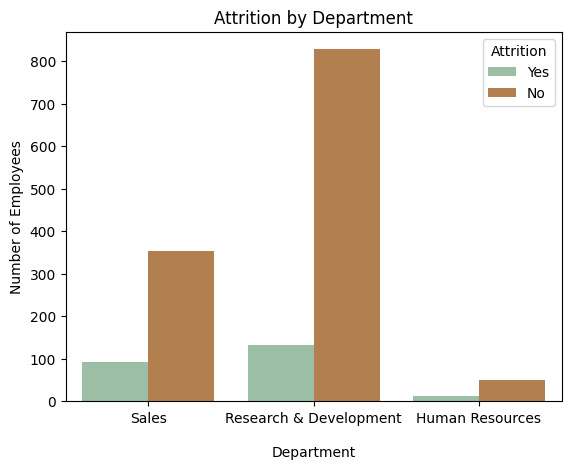

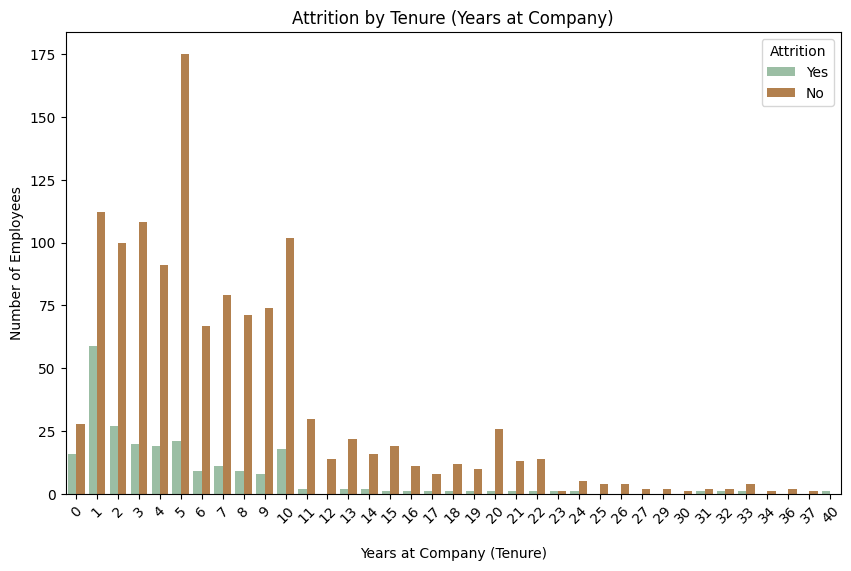

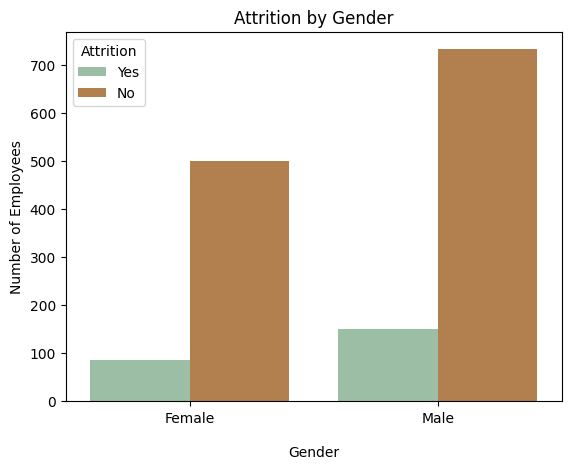

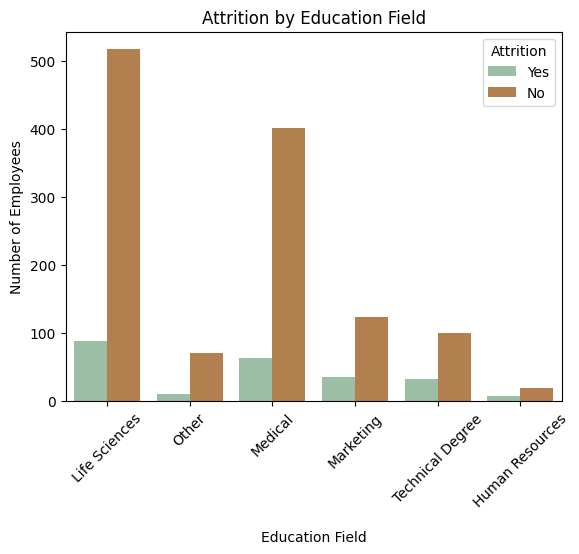

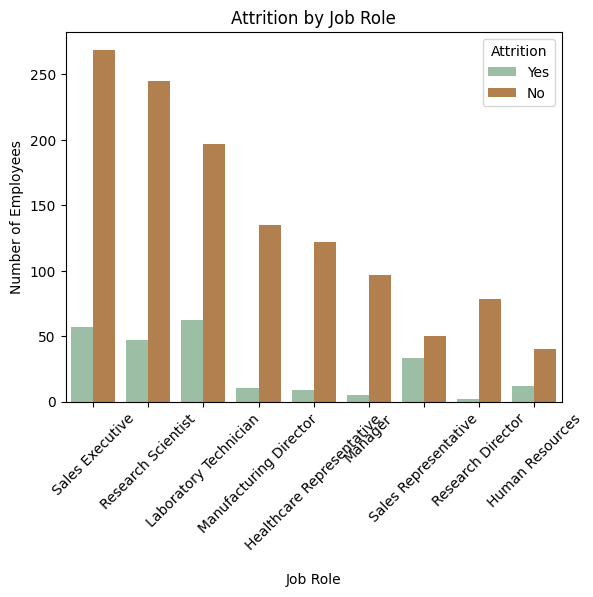

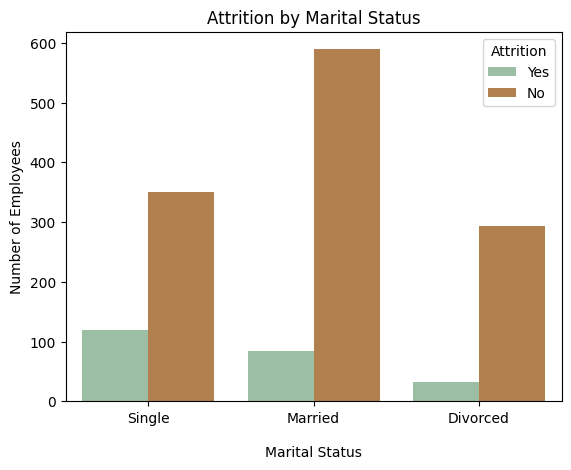

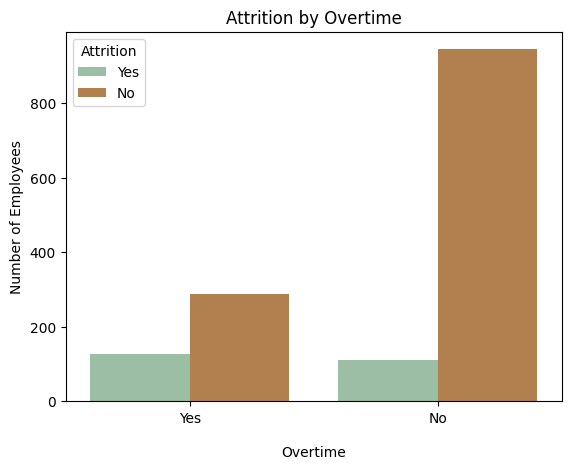

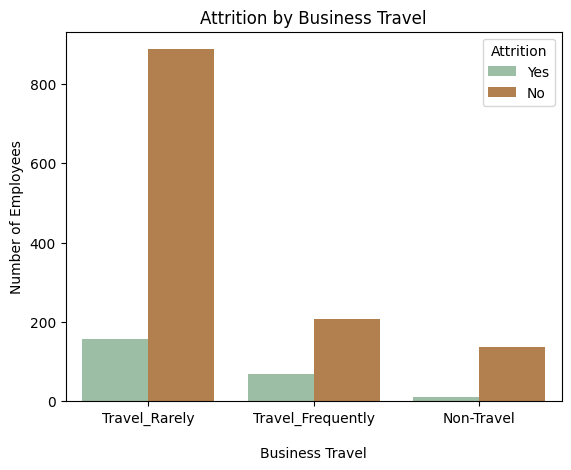

In [5]:
## Categorical Variables: sns.countplot

# Presentation palette
colors = ['#95C4A1', '#C3803D']

# Attrition by Department
sns.countplot(data = data, x = "Department", hue = "Attrition", palette = colors)
plt.title("Attrition by Department")
plt.xlabel("Department", labelpad = 15)
plt.ylabel("Number of Employees")
plt.show()

# Attrition by Tenure
plt.figure(figsize = (10, 6))
sns.countplot(data = data, x = "YearsAtCompany", hue = "Attrition", palette = colors)
plt.title("Attrition by Tenure (Years at Company)")
plt.xlabel("Years at Company (Tenure)", labelpad = 15)
plt.ylabel("Number of Employees")
plt.xticks(rotation = 45)
plt.show()

# Attrition by Gender
sns.countplot(data = data, x = "Gender", hue = "Attrition", palette = colors)
plt.title("Attrition by Gender")
plt.xlabel("Gender", labelpad = 15)
plt.ylabel("Number of Employees")
plt.show()

# Attrition by Education Field
sns.countplot(data = data, x = "EducationField", hue = "Attrition", palette = colors)
plt.title("Attrition by Education Field")
plt.xlabel("Education Field", labelpad = 15)
plt.ylabel("Number of Employees")
plt.xticks(rotation = 45)
plt.show()

# Attrition by Job Role
sns.countplot(data = data, x = "JobRole", hue = "Attrition", palette = colors)
plt.title("Attrition by Job Role")
plt.xlabel("Job Role", labelpad = 15)
plt.ylabel("Number of Employees")
plt.xticks(rotation = 45)
plt.show()

# Attrition by Marital Status
sns.countplot(data = data, x = "MaritalStatus", hue = "Attrition", palette = colors)
plt.title("Attrition by Marital Status")
plt.xlabel("Marital Status", labelpad = 15)
plt.ylabel("Number of Employees")
plt.show()

# Attrition by Overtime
sns.countplot(data = data, x = "OverTime", hue = "Attrition", palette = colors)
plt.title("Attrition by Overtime")
plt.xlabel("Overtime", labelpad = 15)
plt.ylabel("Number of Employees")
plt.show()

# Attrition by Business Travel
sns.countplot(data = data, x = "BusinessTravel", hue = "Attrition", palette = colors)
plt.title("Attrition by Business Travel")
plt.xlabel("Business Travel", labelpad = 15)
plt.ylabel("Number of Employees")
plt.show()

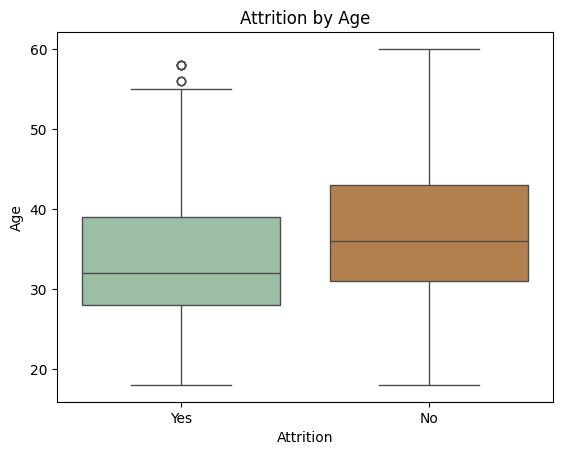

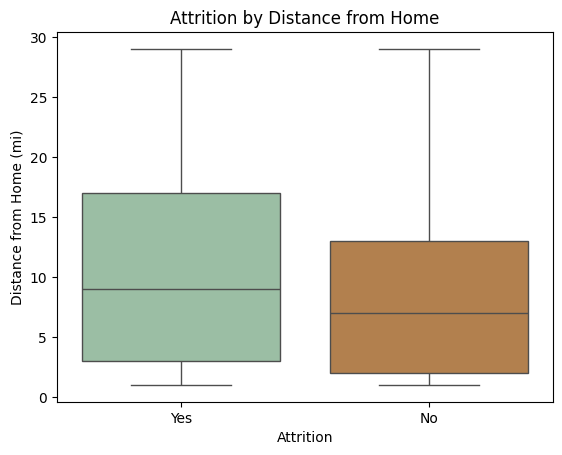

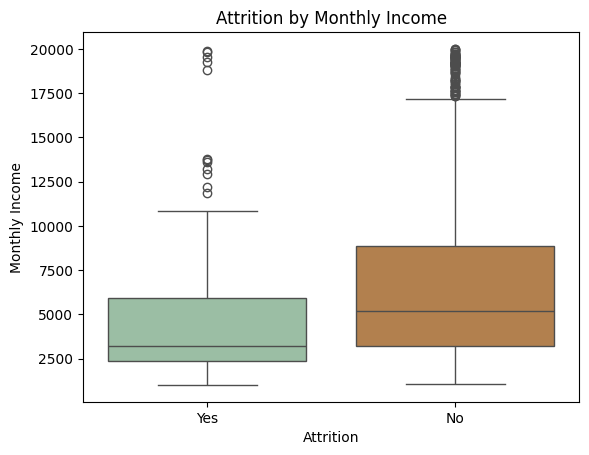

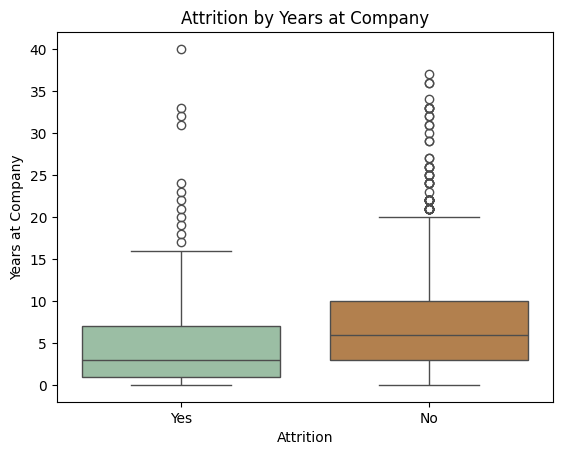

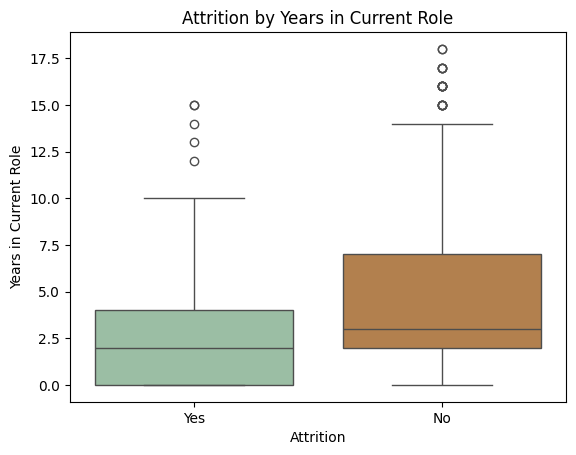

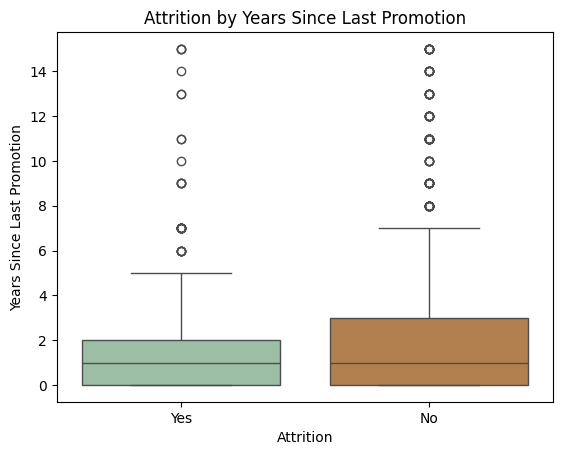

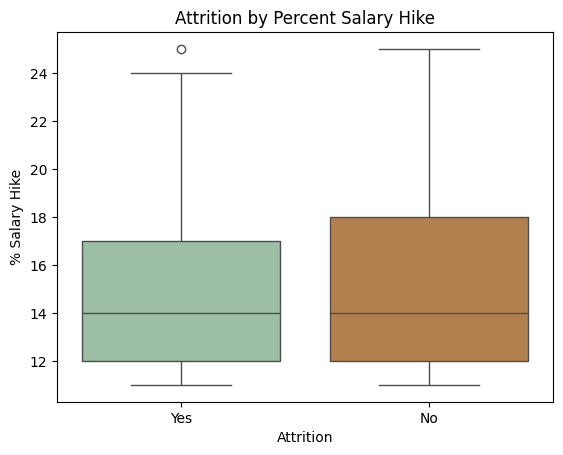

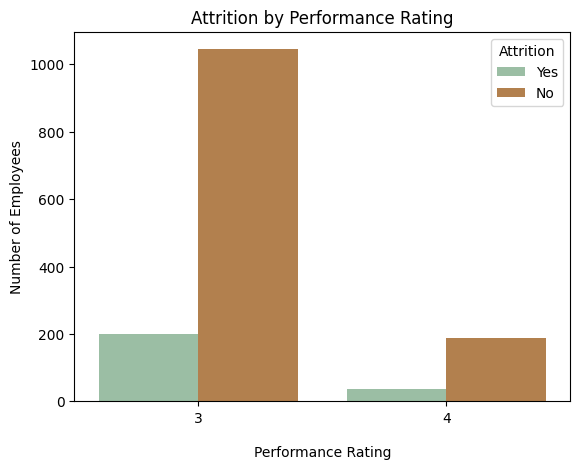

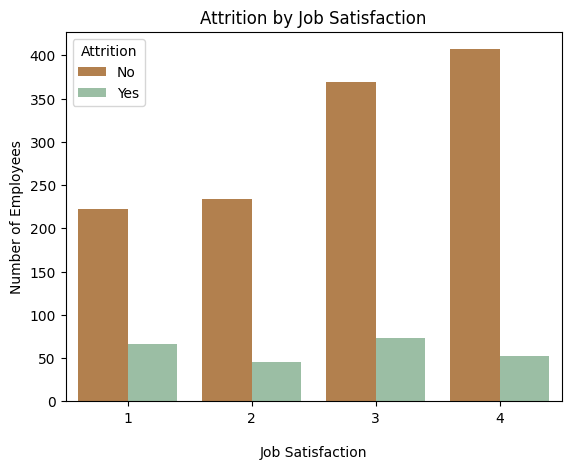

In [6]:
## Numerical Variables: sns.boxplot & sns.countplot

# Attrition by Age
sns.boxplot(y = 'Age', x = 'Attrition', data = data, palette = colors)
plt.title("Attrition by Age")
plt.ylabel("Age")
plt.show()

# Attrition by Distance from Home
sns.boxplot(y = 'DistanceFromHome', x = 'Attrition', data = data, palette = colors)
plt.title("Attrition by Distance from Home")
plt.ylabel("Distance from Home (mi)")
plt.show()

# Attrition by Monthly Income
sns.boxplot(y = 'MonthlyIncome', x = 'Attrition', data = data, palette = colors)
plt.title("Attrition by Monthly Income")
plt.ylabel("Monthly Income")
plt.show()

# Attrition by Years at Company
sns.boxplot(y = 'YearsAtCompany', x = 'Attrition', data = data, palette = colors)
plt.title("Attrition by Years at Company")
plt.ylabel("Years at Company")
plt.show()

# Attrition by Years in Current Role
sns.boxplot(y = 'YearsInCurrentRole', x = 'Attrition', data = data, palette = colors)
plt.title("Attrition by Years in Current Role")
plt.ylabel("Years in Current Role")
plt.show()

# Attrition by Years Since Last Promotion
sns.boxplot(y = 'YearsSinceLastPromotion', x = 'Attrition', data = data, palette = colors)
plt.title("Attrition by Years Since Last Promotion")
plt.ylabel("Years Since Last Promotion")
plt.show()

# Attrition by Percent Salary Hike
sns.boxplot(y = 'PercentSalaryHike', x = 'Attrition', data = data, palette = colors)
plt.title("Attrition by Percent Salary Hike")
plt.ylabel("% Salary Hike")
plt.show()

# Attrition by Performance Rating
sns.countplot(data = data, x = "PerformanceRating", hue = "Attrition", palette = colors)
plt.title("Attrition by Performance Rating")
plt.xlabel("Performance Rating", labelpad = 15)
plt.ylabel("Number of Employees")
plt.show()

# Attrition by Job Satisfaction
sns.countplot(data = data, x = "JobSatisfaction", hue = "Attrition", palette = [colors[1], colors[0]])
plt.title("Attrition by Job Satisfaction")
plt.xlabel("Job Satisfaction", labelpad = 15)
plt.ylabel("Number of Employees")
plt.show()

**Correlation Heatmap**

Next, I will visualize the correlations between all numeric variables in the dataset with a correlation heatmap.

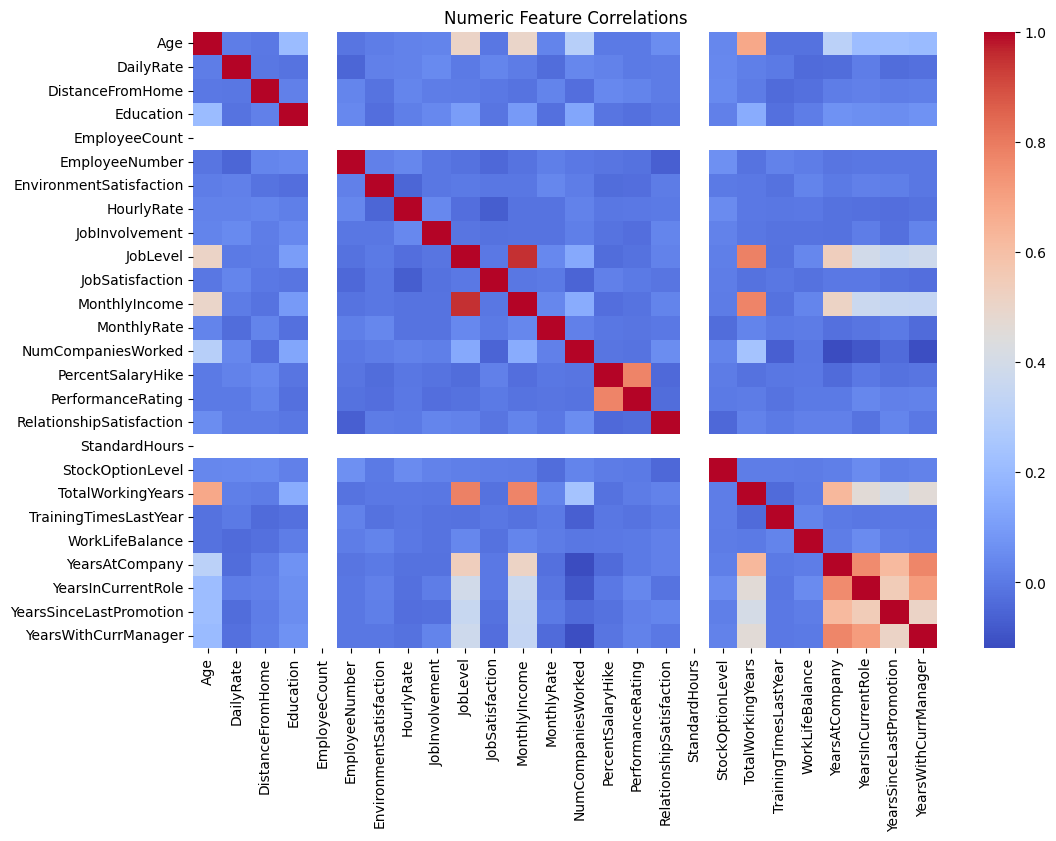

In [7]:
num_data = data.select_dtypes(include=['int64'])

# Correlation heatmap
plt.figure(figsize = (12, 8))
sns.heatmap(num_data.corr(), cmap = "coolwarm")
plt.title("Numeric Feature Correlations")
plt.show()

### Step 3: Preprocessing & Feature Engineering
In this step, I will clean up the dataset to prepare it for and modeling. 

From Step 1 above, we can see that each column contains 1,407 non-null values of varying types. In other words, there are no missing values to omit or impute. However, from the column distributions found on the [Kaggle](https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset) webpage for this dataset, I have found that the following variables do not add value to the analysis and can thus be removed from the dataset: 
1. ```EmployeeCount```: This variable represents the "count" of each employee represented by a row in the dataset, i.e., the value is 1 in each row
2. ```EmployeeNumber```: An arbitrary number is assigned to each employee in the dataset; this number does not lend useful information for the analysis
3. ```Over18```: All employees in the dataset are over the age of 18, thus the value is "Yes" in each row
4. ```StandardHours```: All employees work 80 hours biweekly, resulting in the value of 80 in each row

I will then encode the target variable, Attrition, as ```Yes = 1``` and ```No = 0```, and generate some features that I believe will lend greater insight to the analysis. 

In [3]:
# Drop EmployeeCount, EmployeeNumber, Over18, and StandardHours
data.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis = 1, inplace = True)

# Encode target variable: Attrition
data['Attrition'] = data['Attrition'].apply(lambda x: 1 if x == "Yes" else 0)

#### Feature Engineering

**Overall Satisfaction**

The variables ```JobInvolvement```, ```WorkLifeBalance```, ```JobSatisfaction```, ```RelationshipSatisfaction```, and ```EnvironmentSatisfaction```, each represented as a rating on a scale of 1-5, may be averaged together to create a variable ```OverallSatisfaction```.

In [4]:
# Overall Satisfaction: Average of job involvement, work-life balance, and job, relationship, and environment satisfaction
data['OverallSatisfaction'] = (data['JobInvolvement'] + data['WorkLifeBalance'] + data['JobSatisfaction'] +
                               data['RelationshipSatisfaction'] + data['EnvironmentSatisfaction']) / 5

# Drop individual satisfaction fields
data.drop(['JobInvolvement', 'WorkLifeBalance', 'JobSatisfaction', 'RelationshipSatisfaction', 'EnvironmentSatisfaction'], 
          axis = 1, inplace = True)

**Income**

This dataset contains several "rate" and "income" fields that can introduce redundancy when it comes to modeling. Thus, I will replace these fields with a categorical ```Income``` feature based on the ```MonthlyIncome``` variable, assigning each row to either Low, Medium, or High income categories. 

In [5]:
# Income field calculated using pandas qcut function
data['Income'] = pd.qcut(data['MonthlyIncome'], q = 3, labels = ['Low', 'Medium', 'High'])

# Drop original 'rate' and 'income' fields
data.drop(['DailyRate', 'MonthlyRate', 'MonthlyIncome', 'HourlyRate'], axis = 1, inplace = True)

**Promotion Ratio**

In looking at the time since last promotion, I notice this could be further enriched by expressing the value as a ratio of the employee's total time working at the company. Therefore, I will create a ```PromotionRatio``` feature defined as ```YearsSinceLastPromotion```/```YearsAtCompany``` (correcting for instances of ```YearsAtCompany = 0```).

In [6]:
data['PromotionRatio'] = data['YearsSinceLastPromotion'] / data['YearsAtCompany'].replace(0, 1)

#### Step 4: Modeling

In this step, I will develop the candidate models for predicting employee turnover. The following models have been chosen to be assessed for this case study, along with their rationale & strengths:
1. ```XGBoost```: Often out-performs other models in terms of accuracy for predicting outcomes like employee turnover
2. ```Random Forest```: An ensemble method that combines multiple decision trees; known for its high predictive accuracy
3. ```Gradient Boosted Tree```: Another powerful ensemble method that can capture complex, non-linear relationships in data
4. ```Logistic Regression```: A common and effective baseline model for binary classification tasks (e.g., predicting "stay" or "leave")
5. ```Support Vector Machines (SVM)```: Effective for binary classification, with both linear and non-linear versions available

**Data Prep**

In [7]:
# Separate target from predictors
X = data.drop("Attrition", axis = 1)
y = data["Attrition"]

# Identify numeric and categorical variables
numeric = X.select_dtypes(include = ['int64', 'float64']).columns.tolist()
categorical = X.select_dtypes(include = ['object', 'category']).columns.tolist()

print("Numeric columns:", numeric)
print("Categorical columns:", categorical)

Numeric columns: ['Age', 'DistanceFromHome', 'Education', 'JobLevel', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'OverallSatisfaction', 'PromotionRatio']
Categorical columns: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime', 'Income']


In [8]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

**Pre-processing Pipeline**

In [9]:
# Create pipelines to impute and encode numeric and categorical variables
numeric_trans = Pipeline(steps=[('imputer', SimpleImputer(strategy = 'median')),
                                      ('scaler', StandardScaler())])
categorical_trans = Pipeline(steps=[('imputer', SimpleImputer(strategy = 'most_frequent')),
                                          ('onehot', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False))])

# Create preprocessor for scaling
preprocessor_scale = ColumnTransformer(transformers=[('num', numeric_trans, numeric), ('cat', categorical_trans, categorical), ], remainder='drop')

# Create preprocessor that does not scale numeric (for tree-based models)
numeric_trans_noscale = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),])
preprocessor_noscale = ColumnTransformer(transformers=[('num', numeric_trans_noscale, numeric),
                                                       ('cat', categorical_trans, categorical)], remainder='drop')

**Model Pipelines & Hyperparameter Distributions**

In [13]:
# Create dictionary to hold all 5 model pipelines
pipelines = {
    'LogisticRegression': Pipeline([
        ('pre', preprocessor_scale),
        ('clf', LogisticRegression(max_iter = 5000, solver = 'saga', random_state = 42))
    ]),
    'SVM': Pipeline([
        ('pre', preprocessor_scale),
        ('clf', SVC(kernel = 'rbf', probability = True, random_state = 42))
    ]),
    'RandomForest': Pipeline([
        ('pre', preprocessor_noscale),
        ('clf', RandomForestClassifier(random_state = 42, n_jobs = -1))
    ]),
    'GradientBoosting': Pipeline([
        ('pre', preprocessor_noscale),
        ('clf', GradientBoostingClassifier(random_state = 42))
    ]),
    'XGBoost': Pipeline([
        ('pre', preprocessor_noscale),
        ('clf', xgb.XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', random_state = 42, n_jobs = -1))
    ])
}

# Create hyperparameter distributions (for RandomizedSearch cross-valildation)
param_distributions = {
    'LogisticRegression': {
        'clf__C': uniform(0.01, 10),
        'clf__l1_ratio': uniform(0, 1), 
        'clf__penalty': ['l2', 'elasticnet'] 
    },
    'SVM': {
        'clf__C': uniform(0.1, 10),
        'clf__gamma': ['scale', 'auto'],
        'clf__kernel': ['rbf'] 
    },
    'RandomForest': {
        'clf__n_estimators': randint(100, 500),
        'clf__max_depth': [None] + list(range(3, 20)),
        'clf__min_samples_split': randint(2, 10),
        'clf__class_weight': [None, 'balanced']
    },
    'GradientBoosting': {
        'clf__max_leaf_nodes': randint(10, 200),
        'clf__learning_rate': uniform(0.01, 0.5)
    },
    'XGBoost': {
        'clf__n_estimators': randint(100, 500),
        'clf__max_depth': randint(3, 12),
        'clf__learning_rate': uniform(0.01, 0.5),
        'clf__subsample': uniform(0.5, 0.5),
        'clf__colsample_bytree': uniform(0.3, 0.7)
    }
}

**Hyperparameter Tuning**

Here, I will define a repeatable function for hyperparameter tuning then implement the function on our model pipelines.

In [16]:
# Define a search & fit function that performs hyperparameter tuning and returns 
# best parameters and ROC AUC score for each pipeline
def run_random_search(name, pipeline, param_dist, X_tr, y_tr, n_iter = 40):
    print(f"\nRunning RandomizedSearchCV for: {name}")
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    search = RandomizedSearchCV(
        pipeline,
        param_distributions = param_dist,
        n_iter = n_iter,
        scoring = 'roc_auc',
        n_jobs = -1,
        cv = cv,
        verbose = 1,
        random_state = 42,
        return_train_score = False
    )
    search.fit(X_tr, y_tr)
    print("Best parameters:", search.best_params_)
    print("Best CV ROC AUC:", search.best_score_)
    return search.best_estimator_, search

In [17]:
# Hyperparameter tuning on our 5 pipelines
best_estimators = {}
search_objects = {}

for name, pipe in pipelines.items():
    if name in param_distributions:
        best_est, search_obj = run_random_search(name, pipe, param_distributions[name], X_train, y_train)
        best_estimators[name] = best_est
        search_objects[name] = search_obj
    else:
        # fit defaults
        print(f"Fitting default for {name}")
        pipe.fit(X_train, y_train)
        best_estimators[name] = pipe


Running RandomizedSearchCV for: LogisticRegression
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters: {'clf__C': np.float64(1.2303823484477883), 'clf__l1_ratio': np.float64(0.4951769101112702), 'clf__penalty': 'l2'}
Best CV ROC AUC: 0.8504472996057288

Running RandomizedSearchCV for: SVM
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters: {'clf__C': np.float64(1.4949386065204184), 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}
Best CV ROC AUC: 0.8463635823908333

Running RandomizedSearchCV for: RandomForest
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters: {'clf__class_weight': None, 'clf__max_depth': 18, 'clf__min_samples_split': 9, 'clf__n_estimators': 262}
Best CV ROC AUC: 0.8353668936223038

Running RandomizedSearchCV for: GradientBoosting
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters: {'clf__learning_rate': np.float64(0.10171739493308189), 'clf__max_leaf_nodes': 81}
Be

**Model Evaluation**

In [18]:
# Evaluate on test set

# Define a model evaluation function
def evaluate_model(name, model, X_te, y_te):
    y_pred = model.predict(X_te)
    y_proba = model.predict_proba(X_te)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_te)
    metrics = {
        'Accuracy': accuracy_score(y_te, y_pred),
        'Precision': precision_score(y_te, y_pred, zero_division = 0),
        'Recall': recall_score(y_te, y_pred, zero_division = 0),
        'F1': f1_score(y_te, y_pred, zero_division = 0),
        'ROC_AUC': roc_auc_score(y_te, y_proba),
        'PR_AUC': average_precision_score(y_te, y_proba),
        'ConfusionMatrix': confusion_matrix(y_te, y_pred)
    }
    fpr, tpr, _ = roc_curve(y_te, y_proba)
    precision, recall, _ = precision_recall_curve(y_te, y_proba)
    return metrics, (fpr, tpr), (precision, recall)

# Iterate through models and implement evaluation function
results = {}
for name, model in best_estimators.items():
    print(f"\nEvaluating {name} on test set")
    metrics, roc_curve_data, pr_curve_data = evaluate_model(name, model, X_test, y_test)
    results[name] = {
        'Model': model,
        'Metrics': metrics,
        'ROC': roc_curve_data,
        'PR': pr_curve_data
    }
    print(name, metrics)


Evaluating LogisticRegression on test set
LogisticRegression {'Accuracy': 0.8707482993197279, 'Precision': 0.68, 'Recall': 0.3617021276595745, 'F1': 0.4722222222222222, 'ROC_AUC': 0.8193642863295718, 'PR_AUC': 0.588834398510659, 'ConfusionMatrix': array([[239,   8],
       [ 30,  17]])}

Evaluating SVM on test set
SVM {'Accuracy': 0.8707482993197279, 'Precision': 0.8, 'Recall': 0.2553191489361702, 'F1': 0.3870967741935484, 'ROC_AUC': 0.8305624946162461, 'PR_AUC': 0.5659441990033492, 'ConfusionMatrix': array([[244,   3],
       [ 35,  12]])}

Evaluating RandomForest on test set
RandomForest {'Accuracy': 0.8469387755102041, 'Precision': 0.5833333333333334, 'Recall': 0.14893617021276595, 'F1': 0.23728813559322035, 'ROC_AUC': 0.801274872943406, 'PR_AUC': 0.4680803745134732, 'ConfusionMatrix': array([[242,   5],
       [ 40,   7]])}

Evaluating GradientBoosting on test set
GradientBoosting {'Accuracy': 0.8367346938775511, 'Precision': 0.48148148148148145, 'Recall': 0.2765957446808511, 'F1'

**Model Summaries**

In [24]:
# Generate a summary table of models' performance
summary_rows = []
for name, res in results.items():
    m = res['Metrics']
    summary_rows.append({
        'Model': name,
        'Accuracy': m['Accuracy'],
        'Precision': m['Precision'],
        'Recall': m['Recall'],
        'F1': m['F1'],
        'ROC_AUC': m['ROC_AUC'],
        'PR_AUC': m['PR_AUC']
    })
summary_df = pd.DataFrame(summary_rows)
print("\nPerformance summary (sorted by ROC AUC):")
display(summary_df.style.format({
    'Accuracy': "{:.3f}",
    'Precision': "{:.3f}",
    'Recall': "{:.3f}",
    'F1': "{:.3f}",
    'ROC_AUC': "{:.3f}",
    'PR_AUC': "{:.3f}"
}))


Performance summary (sorted by ROC AUC):


,Model,Accuracy,Precision,Recall,F1,ROC_AUC,PR_AUC
0,LogisticRegression,0.871,0.680,0.362,0.472,0.819,0.589
1,SVM,0.871,0.800,0.255,0.387,0.831,0.566
2,RandomForest,0.847,0.583,0.149,0.237,0.801,0.468
3,GradientBoosting,0.837,0.481,0.277,0.351,0.763,0.459
4,XGBoost,0.857,0.609,0.298,0.400,0.793,0.489


**ROC Curves & Precision-Recall Curves**

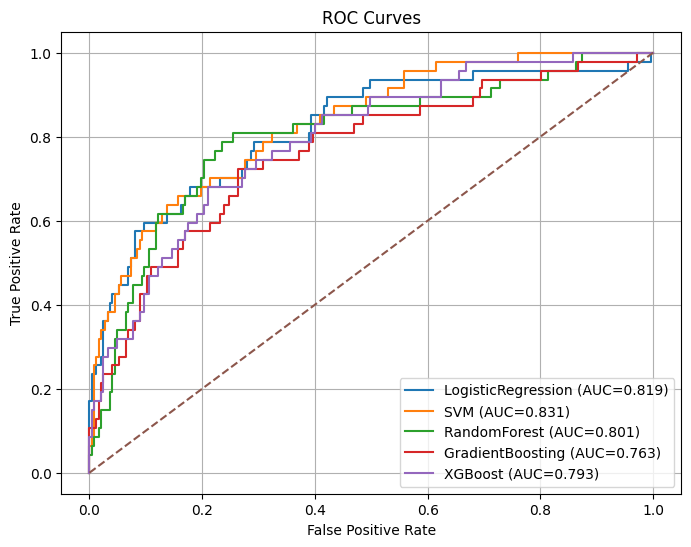

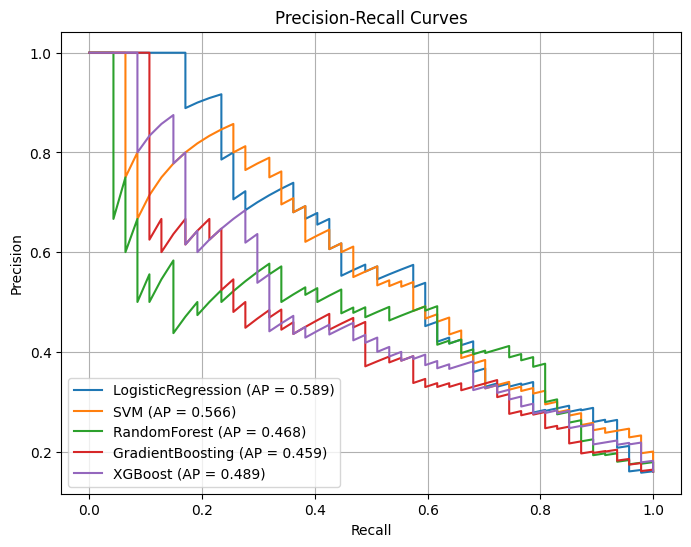

In [20]:
# Plot ROC curves
plt.figure(figsize = (8,6))
for name, res in results.items():
    fpr, tpr = res['ROC']
    plt.plot(fpr, tpr, label = f"{name} (AUC={res['Metrics']['ROC_AUC']:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc = 'lower right')
plt.grid(True)
plt.show()

# Plot Precision-Recall curves
plt.figure(figsize = (8,6))
for name, res in results.items():
    prec, rec = res['PR']
    plt.plot(rec, prec, label = f"{name} (AP = {res['Metrics']['PR_AUC']:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend(loc = 'lower left')
plt.grid(True)
plt.show()

### Step 5: Explainability (Feature Importance for tree-based models)


LogisticRegression Feature Importance:


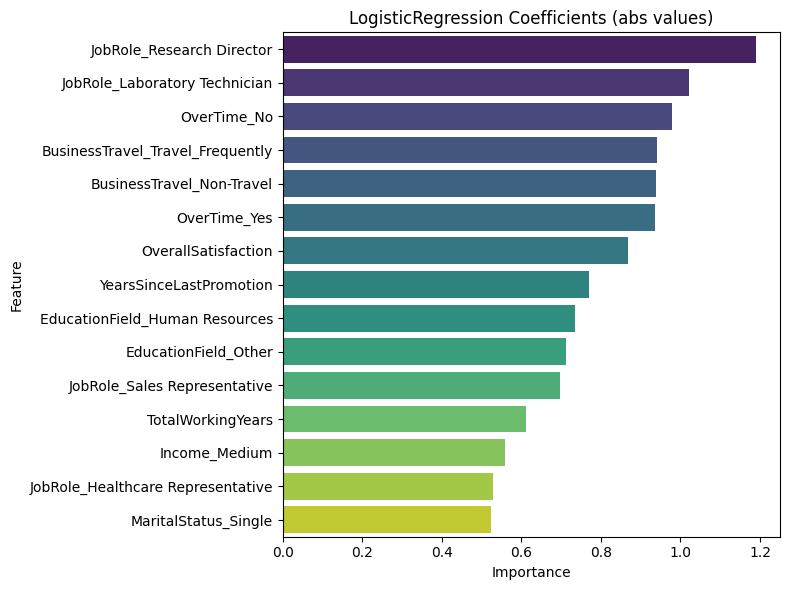


RandomForest Feature Importance:


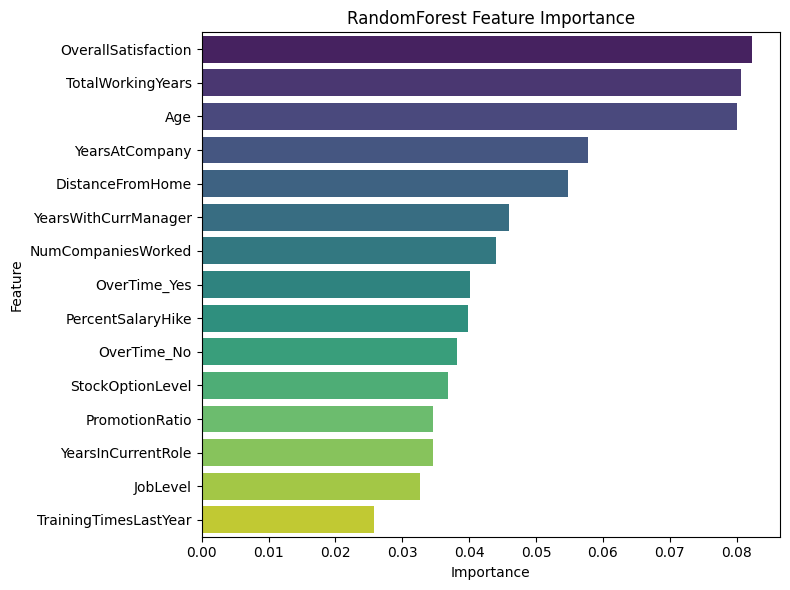


GradientBoosting Feature Importance:


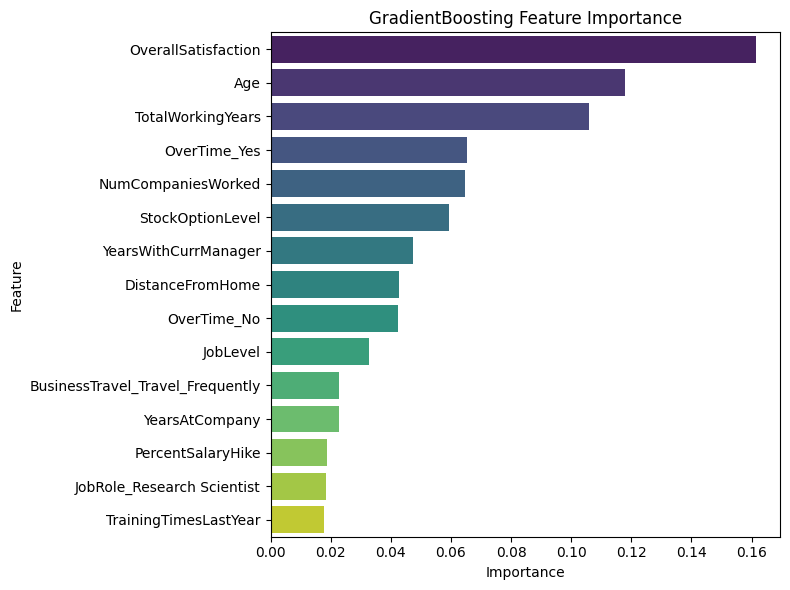


XGBoost Feature Importance:


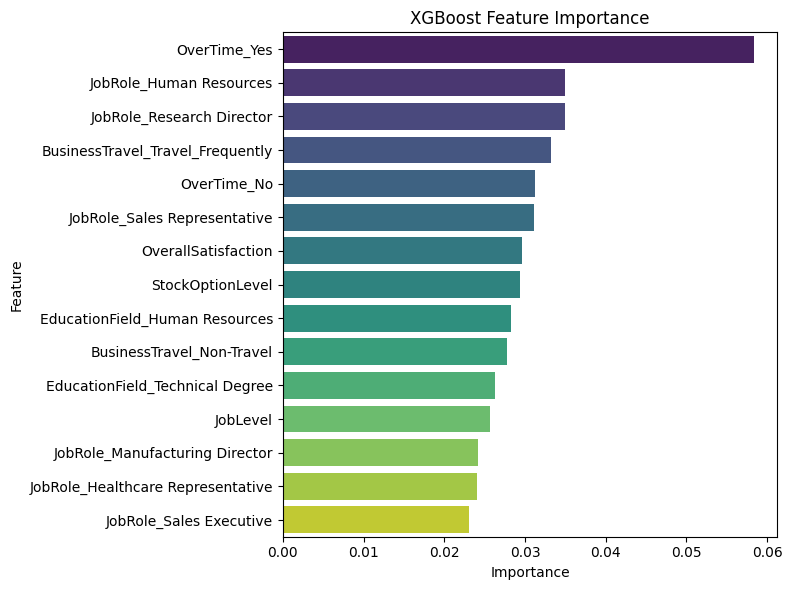

In [21]:
# Define a function for getting numeric & categorical feature names
def get_feature_names(preprocessor):
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_columns = ohe.get_feature_names_out(categorical)
    num_columns = numeric
    return list(num_columns) + list(cat_columns)

# Define a function for repeatability that plots feature importance
def plot_feature_importance(importances, feature_names, title):
    fi = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    fi = fi.sort_values(by = 'Importance', ascending = False).head(15)
    plt.figure(figsize=(8, 6))
    sns.barplot(x = 'Importance', y = 'Feature', data = fi, palette = 'viridis')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

# Refit tree-based and linear models directly on transformed data for importance extraction
for name, pipe in best_estimators.items():
    if name == 'SVM':
        continue  # SVM does not provide simple feature importance
    print(f"\n{name} Feature Importance:")
    pre = pipe.named_steps['pre']
    clf = pipe.named_steps['clf']
    feature_names = get_feature_names(pre)

    if hasattr(clf, 'feature_importances_'): # If the model has 'feature importance' attribute
        importances = clf.feature_importances_
        plot_feature_importance(importances, feature_names, f"{name} Feature Importance")
    elif hasattr(clf, 'coef_'): # If the model has 'coef' attribute
        importances = np.abs(clf.coef_).ravel()
        plot_feature_importance(importances, feature_names, f"{name} Coefficients (abs values)")
    else: # If the type of model does not yield feature importances
        print(f"{name} does not support feature importance extraction.")

### Step 6: Save files

In [25]:
# Save model summaries to CSV
summary_df.to_csv('03-ModelComparisonSummary.csv', index = False)
print('Saved summary to 03-ModelComparisonSummary.csv')

Saved summary to 03-ModelComparisonSummary.csv


In [27]:
# Iterate through models and store feature importances
feature_importances_list = []
for name, pipe in best_estimators.items():
    if name == 'SVM':
        continue  # SVM does not provide simple feature importance
    print(f"\n{name} Feature Importance:")
    pre = pipe.named_steps['pre']
    clf = pipe.named_steps['clf']
    feature_names = get_feature_names(pre)

    if hasattr(clf, 'feature_importances_'):
        importances = clf.feature_importances_
    elif hasattr(clf, 'coef_'):
        importances = np.abs(clf.coef_).ravel()
    else:
        continue

    fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by = 'Importance', ascending = False)

    # Save each model’s importances to its own CSV file
    filename = f'{name}-FeatureImportance.csv'
    fi_df.to_csv(filename, index = False)
    print(f'Saved {filename} ({len(fi_df)} features)')

    # Store for combined summary 
    fi_df['Model'] = name
    feature_importances_list.append(fi_df)

# Combine all model importances into one dataframe
combined_fi_df = pd.concat(feature_importances_list, ignore_index = True)
combined_fi_df.to_csv('04-FeatureImportance-AllModels.csv', index = False)


LogisticRegression Feature Importance:
Saved LogisticRegression-FeatureImportance.csv (47 features)

RandomForest Feature Importance:
Saved RandomForest-FeatureImportance.csv (47 features)

GradientBoosting Feature Importance:
Saved GradientBoosting-FeatureImportance.csv (47 features)

XGBoost Feature Importance:
Saved XGBoost-FeatureImportance.csv (47 features)


In [8]:
# Map Attrition variable back to 'Yes' and 'No' for further visualizations
data['Attrition'] = data['Attrition'].map({1 : 'Yes', 0 : 'No'})
# Save final cleaned dataset with added features
data.to_csv('05-IBMAttritionData_cleaned.csv', index = False)